In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Loading audio file

In [3]:
audio_path = '../Fifa-vocal-noise-rem-only.aac'
scale, sampling_rate = librosa.load(audio_path)

/tmp/ipykernel_61415/3590508323.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  scale, sampling_rate = librosa.load(audio_path)
/home/jitheesh/.local/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


## Extracting Mel spectrogram

In [4]:
mel_spectrogram = librosa.feature.melspectrogram(y=scale, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=10)

In [5]:
mel_spectrogram.shape

(10, 65066)

In [6]:
def display(mel_spectrogram):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(mel_spectrogram,
                            x_axis='time',
                            y_axis='mel',
                            sr=sampling_rate)
    plt.show()
    

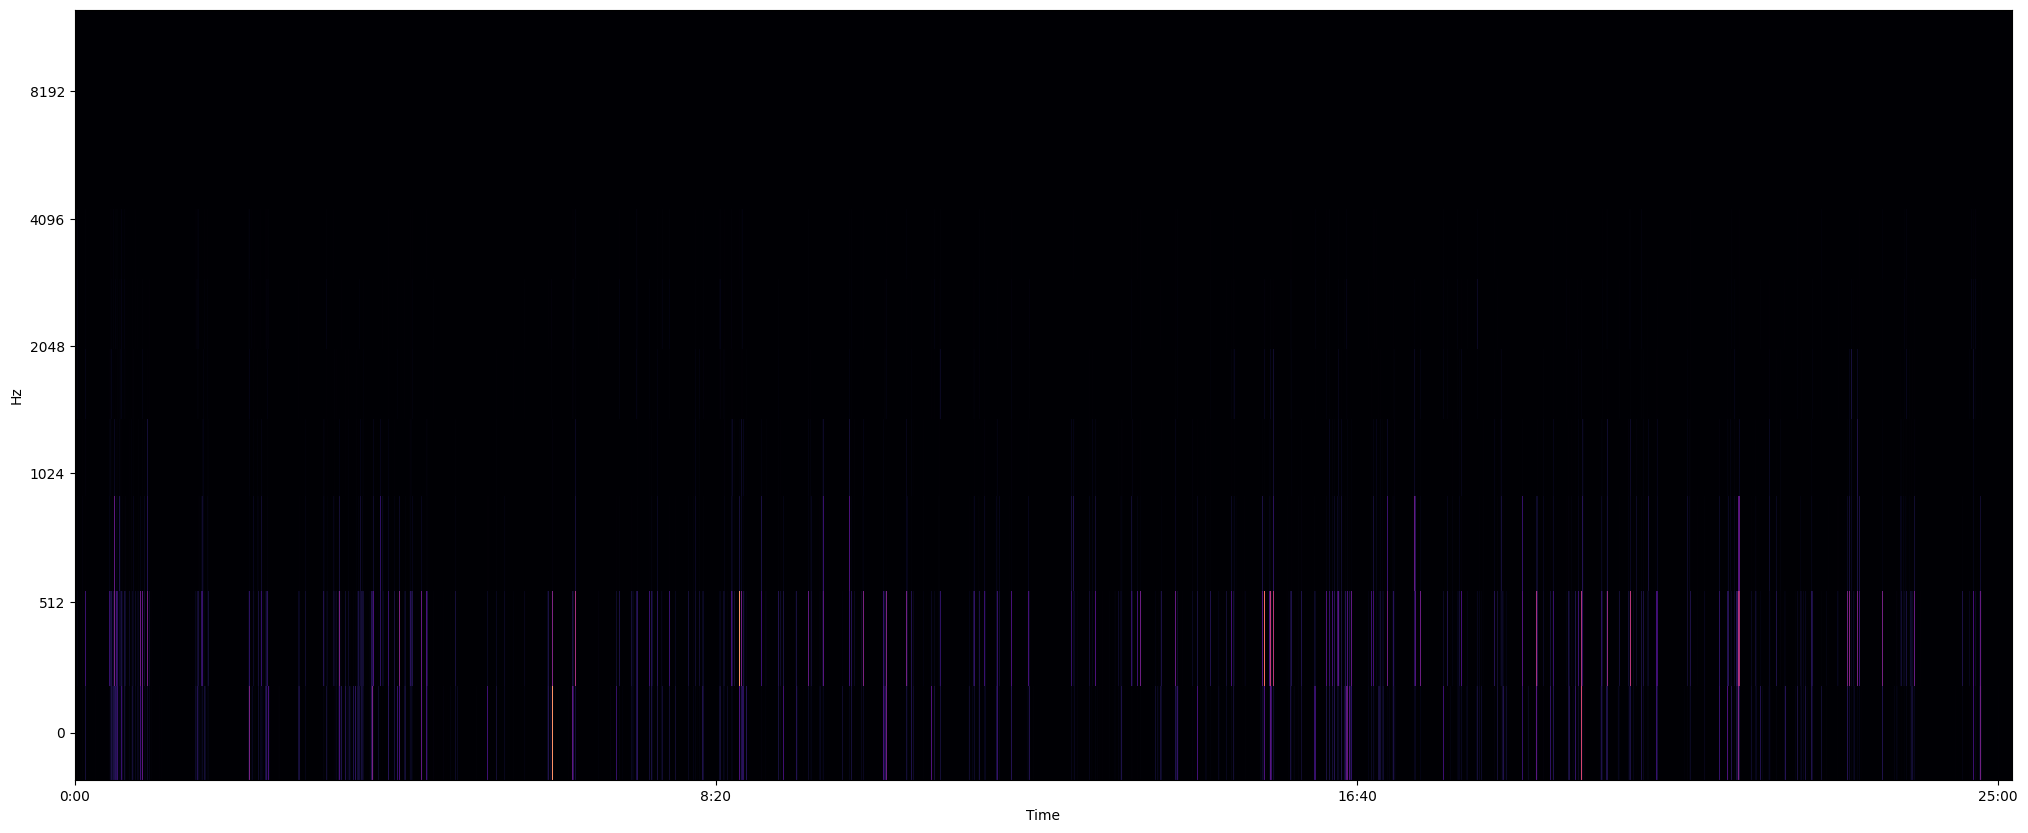

In [7]:
display(mel_spectrogram=mel_spectrogram)

In [8]:
log_mel_spectogram = librosa.power_to_db(mel_spectrogram)

In [9]:
log_mel_spectogram.shape

(10, 65066)

In [10]:
print(mel_spectrogram)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.7786587e-24
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.4483341e-24
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 1.5201232e-24
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.9901324e-25
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.9801691e-25
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 4.0028725e-25
  0.0000000e+00 0.0000000e+00]]


In [11]:
display(log_mel_spectogram)

## Mel spectrogram for each segment

### Calculate the total number of intervals

In [ ]:
interval_length = 10
total_duration = len(scale) / sampling_rate
num_intervals = int(total_duration // interval_length)

### Calculate the Mel spectrogram for each interval

In [ ]:
mel_spectrograms = list()
for interval in range(num_intervals):
    # Define the start and end index for the current interval
    start_index = interval * interval_length * sampling_rate
    end_index = (interval + 1) * interval_length * sampling_rate

    # Get the audio slice for the current interval
    interval_audio = scale[start_index:end_index]

    # Obtain the Mel spectrogram for the interval
    interval_mel_spec = librosa.feature.melspectrogram(y=interval_audio, sr=sampling_rate, n_fft=2048, hop_length=512, n_mels=10)

    interval_log_mel_spec = librosa.power_to_db(interval_mel_spec)

    # Append the Mel spectrogram to the list
    mel_spectrograms.append(interval_log_mel_spec)

In [ ]:
print(mel_spectrograms[0])

[[-66.75591  -66.75591  -66.75591  ... -25.45757  -24.77095  -28.628613]
 [-66.75591  -66.75591  -66.75591  ... -27.730799 -29.206364 -36.79786 ]
 [-66.75591  -66.75591  -66.75591  ... -30.339321 -32.12795  -39.6887  ]
 ...
 [-66.75591  -66.75591  -66.75591  ... -29.788504 -31.424818 -37.75019 ]
 [-66.75591  -66.75591  -66.75591  ... -29.34147  -30.47892  -36.91149 ]
 [-66.75591  -66.75591  -66.75591  ... -31.450481 -32.008816 -37.364136]]


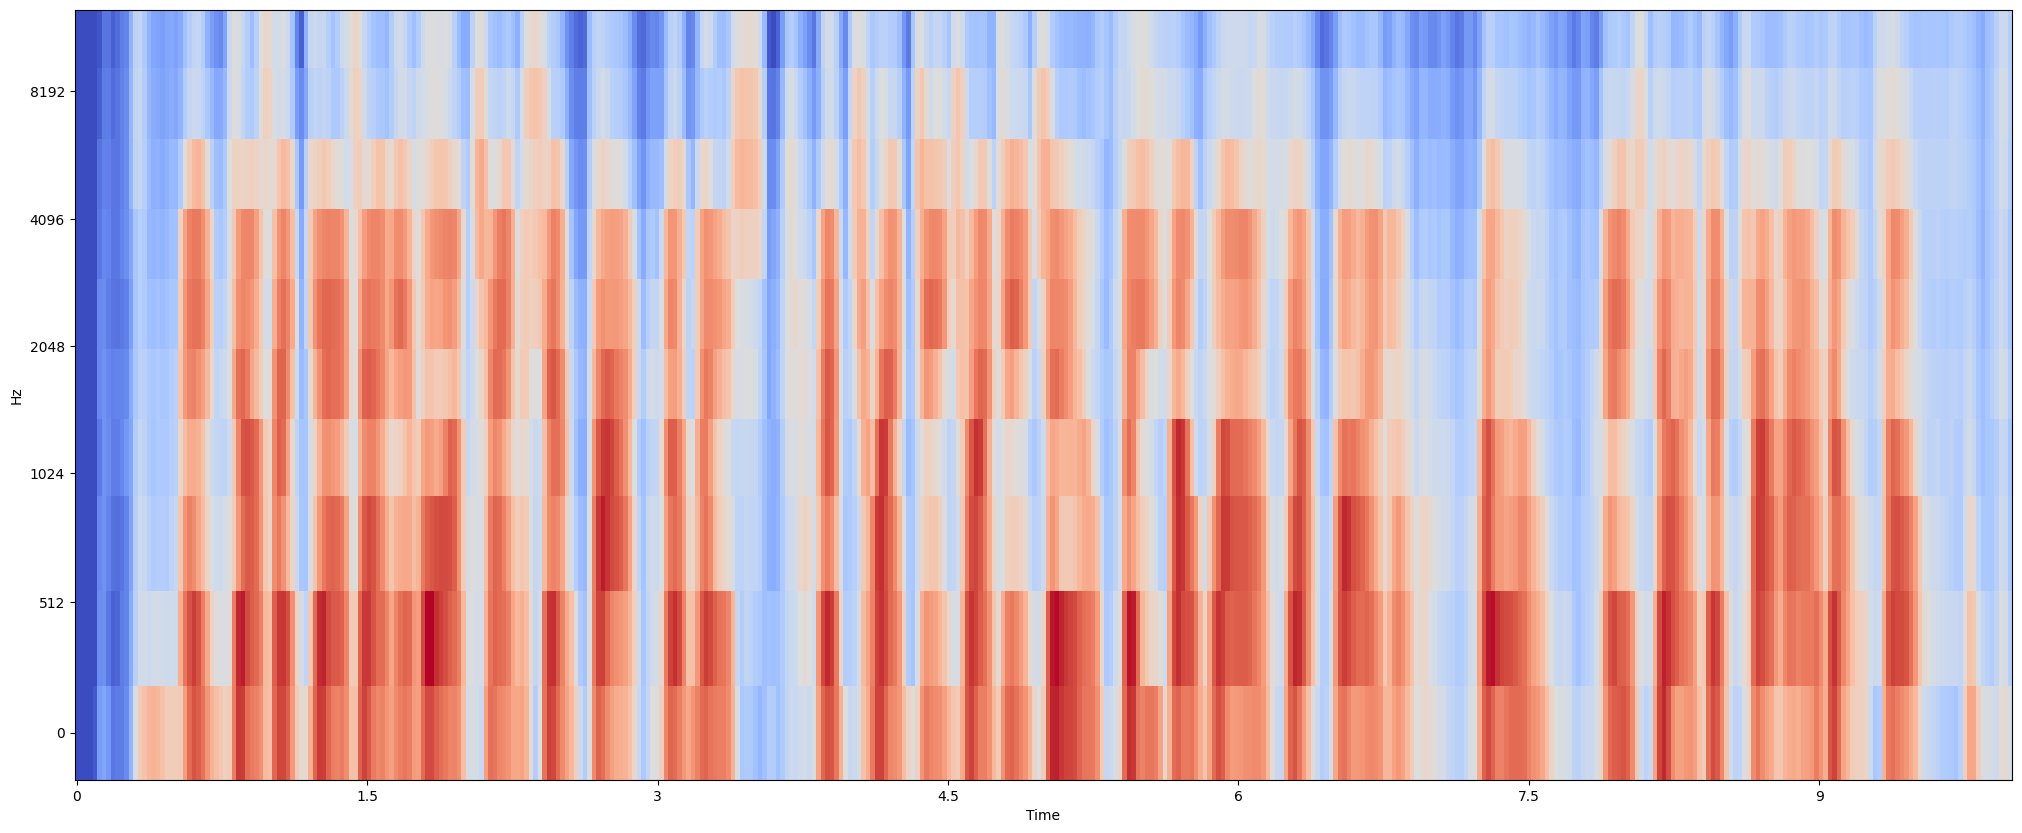

In [ ]:
display(mel_spectrograms[0])

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('prediction.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Audio ID          151 non-null    object 
 1   Start time        151 non-null    object 
 2   Highlight ID      61 non-null     object 
 3   Output Category   151 non-null    int64  
 4   Amplitude         151 non-null    float64
 5   Final prediction  151 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 7.2+ KB


In [ ]:
len(mel_spectrograms)

151

In [ ]:
len(df)

151

In [ ]:
actual_values = df['Output Category']

In [ ]:
# Convert to numpy arrays and add a channel dimension
mel_spectrograms = np.array(mel_spectrograms)
mel_spectrograms = mel_spectrograms[..., np.newaxis]  # Add channel dimension

In [ ]:
mel_train, mel_test,  actual_train, actual_test = train_test_split(mel_spectrograms, actual_values,
                                                                    random_state=104,  
                                                                    test_size=0.25,  
                                                                    shuffle=False)

In [ ]:
(len(mel_train), len(mel_test), len(actual_train), len(actual_test))

(113, 38, 113, 38)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

2024-05-25 12:41:06.194701: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-25 12:41:06.229137: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 12:41:06.864696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
# Input shape
input_shape = mel_spectrograms[0].shape
# mel_spectrograms[0].shape

In [ ]:
num_classes = 2
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(mel_train, actual_train, epochs=10)

: 

: 